## The goal of this notebook is to combine different behavioral data into stored at different resolutions into a single dataframe.

### Initially we're juggling three forms of the data:
1. **analog**: 200Hz sampling of state; we *do* get trial info (`nTrial`) but not block (`iBlock`)
   - block info can easily be filled in using trials_df (below)
   - sometimes there is an issue with analog catching up where session start is missing (flagged)
   - `sTrial_start`, `sTrial_end`: start and end state corresponding to each lick
   - `iTrial`: empty, not sure what that's supposed to contain
   - `iOccurrence`: sample index for each trial

2. **lick_df**: we get spout direction (`iSpout`) but trial and block labels are missing (`iBlock`, `iTrial`)
   - `sTrial_start`, `sTrial_end`: start and end state corresponding to each lick (match with above)
   - `tState`: duration of the state transition
   - function: logs every lick from session


3. **trials_df**: trial based behavior data; contains info necessary for classifying trial types
   - contains block information for each trial
   - useful to identify timeout trials
   

**First goal of the notebook:** Fill in `iBlock` and `iTrial` for lick_df and leave a mapping back to analog

### Finally, we map licks onto the analog behavioral sampling dataframe and label task state transitions (binary columns)

- merge between `analog` and `lick_df` using set of columns that provide unique ID for each lick:
    - `nTrial`: trial number
    - `iState_start`, `iState_end`: state transition
    - `tState`: duraction within iState_start up to transition
        - To map licks between `lick_df` (dataframe where each row stores a lick and corresponding state transition, state duration) to `analog`, we need to calculate the timing of state transitions (`tState`) in analog.
    - `n_ENL`: position of ENL period within trial (because ENL penalties do not lead to a unique state)
    
- add columns for each important type of state transition, binary representations for when system was in each state


### Load dependencies

In [78]:
import pandas as pd 
import numpy  as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
import os
import sys
from pathlib import Path

path_to_nta = f'{os.path.expanduser("~")}/GitHub/neural-timeseries-analysis/'
sys.path.append(path_to_nta)
import nta.preprocessing.sync_data as sync
import nta.features.behavior_features as bf

sys.path.append(f'{os.path.expanduser("~")}/GitHub/behavior-helpers/')
from bh.preprocessing import pp_helpers

%load_ext autoreload
%autoreload 2

sns.set(style='ticks', font_scale=1.3, rc={'axes.labelsize':25, 'axes.titlesize':25, 'savefig.transparent':True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
mouse = 'C46'
# mouse = 'SCD017'
date = '2021_02_11'
# date = '2023_10_14'
run = ''
exp_day = ''
experimenter = 'Celia'
rig = 'RIG6'

In [19]:
root = Path('/Volumes/Neurobio/MICROSCOPE/Celia/data/lickTask/headfixed_DAB_data')
datapath = root / mouse / f'{date}__{mouse}{run}'
savepath = root / 'preprocessed_data' / mouse / date

if not savepath.exists():
    savepath.mkdir(parents=True, exist_ok=False)

# dataTrial
### Load in dataTrial (`trials_df`) and add some columns that are useful for later analysis

Load experiment parameters to determine if probabilistic or deterministic session. Also sets some other variables necessary for getting path to data correct across variants. Use this to load trial-based data.

In [83]:
conditions = {90:'9010', 10: '9010',
              80:'8020', 20:'8020',
              100: '100-0', 0: '100-0'}

file_mouse = mouse
try:  # standard case
    exp_params = pd.read_excel(os.path.join(datapath, f'{file_mouse}_dataExp_label.xlsx'))
except FileNotFoundError:
    try:  # In case mouse naming defaulted
        exp_params = pd.read_excel(os.path.join(datapath, 'Exp1_TM2_dataExp_label.xlsx'))
        file_mouse = 'Exp1_TM2'
    except FileNotFoundError: # In case needing to process run2
        datapath = datapath.parent / f'{date}__{mouse}_run2'
        exp_params = pd.read_excel(os.path.join(datapath, f'{file_mouse}_dataExp_label.xlsx'))

condition = conditions.get(exp_params.SolenoidProb_R.squeeze())

try:  # hopefully just load in trials with column headers intact
    trials_df = pd.read_excel(os.path.join(datapath, f'{file_mouse}_dataTrial_label.xlsx'))
except FileNotFoundError:  # if no _label file, manually label columns
    with open('column_headers.txt', 'r') as f:
        cols = [col.rstrip() for col in f]
    trials_df = pd.read_csv(os.path.join(datapath, f'{file_mouse}_dataTrial.csv'), names=cols, index_col=None)

## Set up trial data columns

In [84]:
trials_df['Date']= date
trials_df['Mouse']= mouse
trials_df['Condition'] = condition
trials_df['Session'] = '_'.join([mouse,date])
trials_df['timeout'] = trials_df['sSelection'] == 3

base_cols = ['Mouse', 'Date', 'Session', 'Condition', 'sSelection', 'nTrial',
             'tSelection', 'I_giveReward', 'n_ENL', 'n_Cue', 'T_ENL', 'timeout',
             'iBlock']

if condition != '100-0': # probabilistic pp pipeline
    keep_cols = base_cols + ['I_anySelect_R', 'T_Reward', 'DAB_I_flipLR_event', 'DAB_I_flipLR', 'DAB_I_HighProbSel']
    trials_df = (trials_df[keep_cols].copy()
                 .rename(columns={'I_anySelect_R': 'direction',  # right = 1, left = 0
                                  'I_giveReward': 'Reward',
                                  'DAB_I_flipLR': 'State',
                                  'DAB_I_HighProbSel': 'selHigh'}))  
    trials_df.loc[trials_df.sSelection == 3, 'direction'] = np.nan
    trials_df['State'] = 1 - trials_df['State']  # flip to match direction binary

else: # deterministic pp pipeline
    keep_cols = base_cols + ['iSpout', 'iTrial', 'iReward', 'iError', 'L_ENL_trig_n_l1', 'L_Rew_trig_I_l1']
    trials_df = (trials_df[keep_cols].copy()
                 .rename(columns={'iSpout': 'State'}))
    trials_df['Reward'] = (trials_df.iReward>0).astype('int') # reward as a binary
    trials_df = pp_helpers.get_direction(trials_df)  # choice direction, right (0), left (1), TO = NaN

# Add columns that work for both deterministic and probabilistic formats.
trials_df = pp_helpers.define_switches(trials_df)
 # Outcome, switch, high spout post-timeout is NAN.
trials_df.loc[trials_df.timeout == True, ['Switch', 'Reward', 'selHigh']] = np.nan
trials_df = pp_helpers.get_block_pos(trials_df)
trials_df = pp_helpers.get_block_length(trials_df)
trials_df = pp_helpers.flag_blocks_for_timeouts(trials_df, threshold=0.25)

# if save:
#     file_path = savepath / f'{file_mouse}_trials.csv'
#     trials_df.to_csv(file_path, index=True)

# dataLick
### Load in dataLick (`lick_df`), label `nTrial` (pretty roundabout for DAB), fix licks where state transition had no duration

In [ ]:
#papermill_description=LICK_DF
nTrial_exists = False

lick_cols = ['iBlock', 'iTrial', 'iSpout', 'sTrial_start', 'sTrial_end', 'tState']
try:
    lick_df = pd.read_excel(os.path.join(datapath, f'{file_mouse}_dataLick_label.xlsx'), engine='openpyxl')
except FileNotFoundError:
    lick_df = pd.read_csv(os.path.join(datapath, f'{file_mouse}_dataLick.csv'), names=lick_cols)

# timeouts need to be accounted for (may have no licks in lick_df)
timeout_trials = trials_df[trials_df.timeout==1].nTrial.values 
        
if lick_df.columns.tolist() == ['iBlock', 'iTrial', 'iSpout', 'sTrial_start', 'sTrial_end', 'tState']:
    lick_df['nTrial'] = np.nan  # no nTrial col in this case
else:
    #Shifting the names on the columns, so each column has the right label
    # (the raw data has these labels shifted).
    lick_df = (lick_df.rename(columns={'nTrial': 'iBlock',
                                       'iBlock': 'iTrial',
                                       'iTrial': 'iSpout',
                                       'iSpout': 'sTrial_start',
                                       'sTrial_start': 'sTrial_end',
                                       'sTrial_end': 'tState_new',
                                       'tState': 'nTrial'})
                      .rename(columns={'tState_new': 'tState'}))
    
# Weird additional variance in position and contents of column headers??
# I think there was some update to the task code since I last collected data
# that I've noticed in new datasets from others. Not sure if this appropriately 
# addresses it. Seems like maybe you get nTrial or iBlock...?
if (np.all(lick_df.iTrial.diff().dropna() >= 0)) & (~np.all(lick_df.iTrial.eq(0))):
    lick_df = lick_df.drop(columns='nTrial').rename(columns={'iTrial': 'nTrial'})
    nTrial_exists = True
    print(f'{nTrial_exists = }')

lick_df['Date'] = date
lick_df['Mouse'] = mouse

# Delete the first and last rows if they have no lick data (may happen).
if lick_df.iloc[0].sTrial_start == 0:
    lick_df.drop(lick_df.index[0], inplace = True)
if lick_df.iloc[-1].sTrial_start == 0:
    lick_df.drop(lick_df.index[-1], inplace = True)

missing_lick_trials = False if nTrial_exists else np.all(lick_df.iTrial.eq(0))
print(f'{missing_lick_trials = }')
if missing_lick_trials:
    lick_df['nTrial'] = np.nan # for forward filling later; all 0s to start so effectively empty anyway

if missing_lick_trials:
    ... # Add nTrial mapping for dataLick

else:
    if nTrial_exists: # if nTrial is filled properly but not iBlock, can map directly by trial id
        if all(lick_df.iBlock.unique()==0):
            trials_df = trials_df.set_index('nTrial')
            lick_df['iBlock'] = lick_df['nTrial'].map(trials_df['iBlock'])
            trials_df = trials_df.reset_index()
    else:
        block_trial_starts_LUT = lick_df.groupby('iBlock').iTrial.max().cumsum()
        if not block_trial_starts_LUT.get(0, False):
            block_trial_starts_LUT.at[0] = 0
        lick_df = lick_df.query('iBlock > 0').copy()
        lick_df['temp'] = lick_df['iBlock'].values - 1
        lick_df['nTrial'] = lick_df['iTrial'].values + block_trial_starts_LUT.loc[lick_df['temp']].values
        lick_df = lick_df.drop('temp', axis=1)

if save:
    fname = savepath / f'{mouse}_dataLick_filled.csv'
    lick_df.to_csv(fname)

assert np.all(lick_df.nTrial.diff().dropna() >= 0), 'nTrial not ordered monotonically, error in mapping'

In [ ]:
# Rename now so column labels match between lick_df and analog for merging.
lick_df = lick_df.rename(columns={'sTrial_start': 'iState_start',
                                  'sTrial_end': 'iState_end'})
lick_df.iSpout.value_counts()

In [25]:
lick_df.loc[(lick_df.tState==3000) & ~(lick_df.iState_start==53) , 'tState'] = 5 # catching fringe cases at the end of consumption bout

lick_df.loc[(lick_df.tState==0) & ~(lick_df.iState_start==50), 'tState'] = 5 # rectify any 0ms tState, but hold out 50-51 to deal with later

# dataAnalog
### Label blocks, then merge `lick_df` to align licks within timeseries

In [86]:
#papermill_description=ANALOG_START

# Import state transition data from behavioral system (200hz sampling).
fs = 200
analog=pd.read_csv(os.path.join(datapath, f'{file_mouse}_dataAnalog.csv'), header=None) 

analog = sync.set_analog_headers(analog)  # logical method to correctly label columns
analog = sync.trim_to_session_start(analog)  # ensure df starts at current session 

analog['session'] = '_'.join([mouse, date])
analog['session_clock'] = 1 / fs
analog['session_clock'] = analog['session_clock'].cumsum().values
if all(analog.iBlock.unique()==0):  # empty block column fixed in labview code update
    analog['iBlock'] = analog['nTrial'].map(trials_df.set_index('nTrial')['iBlock'])
analog = analog.loc[analog.nTrial > 0] # start at first trial
analog.head()

,nTrial,iBlock,iTrial,iOccurrence,iState_start,iState_end,analog1,analog2,session,session_clock
4,1.0,1.0,0.0,4.0,16.0,20.0,240.0,12.0,T447_2023_12_05,0.025
5,1.0,1.0,1.0,5.0,20.0,21.0,239.0,10.0,T447_2023_12_05,0.030
6,1.0,1.0,1.0,6.0,21.0,14.0,240.0,12.0,T447_2023_12_05,0.035
7,1.0,1.0,1.0,7.0,14.0,24.0,239.0,9.0,T447_2023_12_05,0.040
8,1.0,1.0,1.0,8.0,24.0,25.0,239.0,10.0,T447_2023_12_05,0.045


### count ENLs within trials for correct lick assignment

In [ ]:
def count_ENLs(df):
    
    '''
    add column to df for ENL counter within trial (starting with 1, default)
    '''

    df_ = df.copy()
    
    # 30-32 marks ENL penalty, initialize n_ENL at +2 (ENL initializes at 1,
    # so first penalty is 2nd ENL period).
    ENLs = (df_
            .query('iState_start == 30.0 & iState_end == 32.0')
            .groupby('nTrial').cumcount() + 2
            )
    
    # New column with n_ENL vals at ENL penalty events.
    df_.loc[ENLs.index, 'nENL'] = ENLs.values 

    # fill forward - no longer only in penalty window.
    df_['nENL'] = df_.groupby('nTrial')['nENL'].fillna(method='ffill') 
    
    # NaNs at beginning of each trial - nENL should be 1 there.
    df_['nENL'] = df_['nENL'].fillna(value=1) 

    return df_

In [26]:
analog = count_ENLs(analog) # assign each ENL period its position within a trial for analog
lick_df = count_ENLs(lick_df) # assign each ENL period its position within a trial for lick_df

### calculate state transition times (`tState`) for `analog` to match those of `lick_df`

In [27]:
#papermill_description=STATE_MAPPING

# label rows where starting and stopping states are different as state transitions
analog['state_transition'] = analog.iState_start != analog.iState_end

# need to count UP TO state transition (shifted forward by one?)
analog['transition_count'] = analog.state_transition.cumsum() # give each transition a unique identifier
bins_per_transition = analog.groupby('transition_count').size().values # count samples within each transition
tsteps = [tstep*5 for n_bins in bins_per_transition for tstep in np.arange(1, n_bins+1)] # step through samples with 5ms clock
tsteps.insert(0,0) # shift by 1 - samples for transition time start at first sample for clock 0
analog['tState'] = tsteps[:-1]

### match up licks to rows in analog
Some licks from `lick_df` may not be mapped (don't have exact match in set of identifiers). We return to these later to make sure we can match them to their timepoint.

In [29]:
cols = ['nTrial','iState_start','iState_end', 'tState', 'nENL'] # columns used to uniquely ID each lick

skipped = pd.merge(lick_df, analog, on=cols, how="outer", indicator=True
              ).query('_merge=="left_only"') # save df of licks that fail to merge

analog = analog.merge(lick_df[cols + ['iSpout']], how='left', on=cols) # merge on designated columns to add new column for spout direction

In [30]:
len_skipped = len(skipped)
print(len_skipped)  # how many licks from lick_df could we not find in analog?

2


### Filter out licks that are likely electrical artifacts
Defined as licks that occur within conservatively defined boundary relative to lick cycle (e.g. < 60 ms after preceding lick).

In [32]:
# Drop licks that are too fast to be real (detection issue)
lick_idx = analog.loc[~np.isnan(analog.iSpout)].index.tolist()
n_licks_raw = len(lick_idx)

minInterLickInterval = 12  # *5 = ms

while len(np.where(np.diff(lick_idx) < minInterLickInterval)[0]) > 0:
    x = np.where(np.diff(lick_idx) < minInterLickInterval)[0][0]

    dropped_index = lick_idx[np.where(np.diff(lick_idx) < minInterLickInterval)[0][0] + 1]

    analog.loc[dropped_index, 'iSpout'] = np.nan
    del lick_idx[np.where(np.diff(lick_idx) < minInterLickInterval)[0][0] + 1]

dropped_licks = n_licks_raw - len(lick_idx)

print(f'Dropped {dropped_licks} licks.')


Dropped 73 licks.


### Finally, label task state changes as epochs we think about for analysis

In [36]:
analog = analog.loc[(analog.nTrial.between(trials_df.nTrial.min(), trials_df.nTrial.max()))] # crop analog like trials_df

In [37]:
states_dict = {'ENLP': 'D', 
               'CueP': 'F', 
               'ENL': 'C',
               'Cue': 'E', 
               'Select': ('G','H'),
               'responseTime': 'G', # first to last G, cue to selection time
               'stateConsumption': ('H','H'),
               'TO':('J','J'),
               'initTrial': 'Q',
               'endTrial': 'K',
               'anything_else': 'Z',
               'free_reward': 'P',
              }

states_path = root / 'stateMappings_full.csv'
state_mappings = pd.read_csv(states_path, names=['stateID', 'state','label']).dropna()

state_mappings.loc[state_mappings.label=='I', 'label'] = 'H' # represent select right and select wrong the same for now

# relabel analog states with simplified, interpretable labels
states = state_mappings[['stateID','label']].to_dict()['label']
analog['state1'] = analog['iState_start'].map(states)
analog['state2'] = analog['iState_end'].map(states)

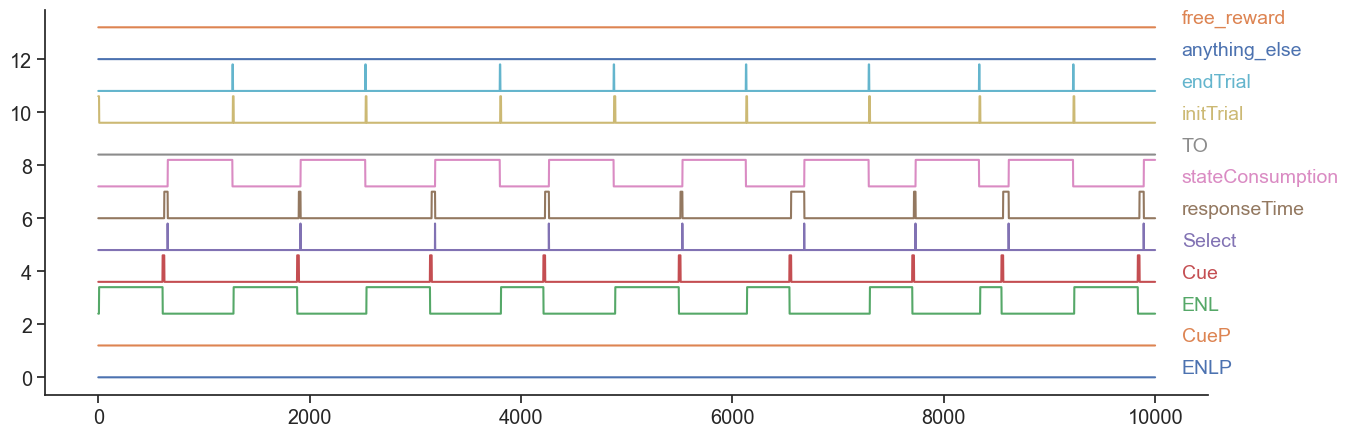

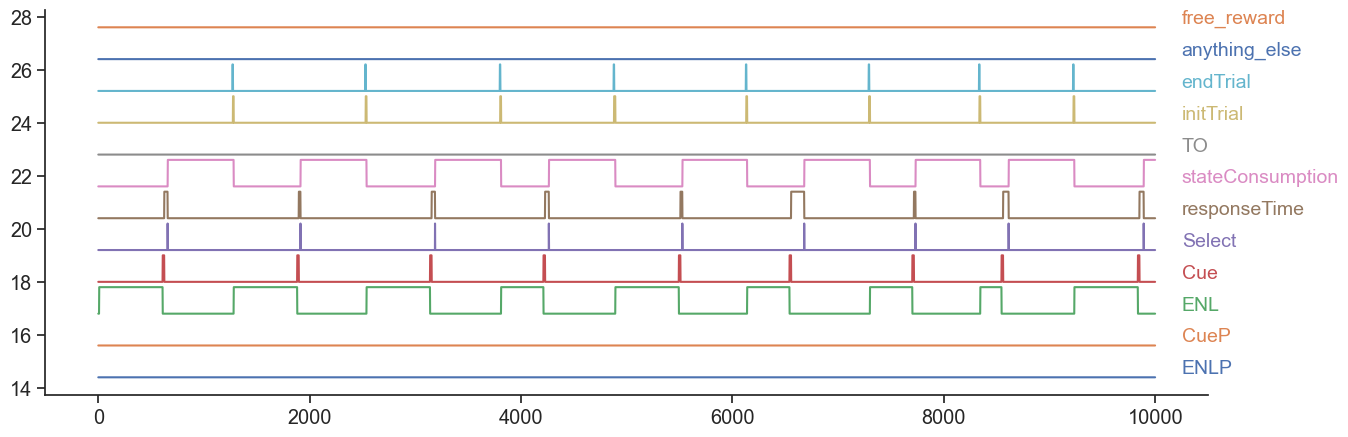

In [49]:
def matching_state_transition(analog, state_transition):
    '''
    Find rows in analog with matching state transition (`iState_start` and `iState_end`), add dummy column to 
    represent this transition
    '''
    if len(state_transition)==1: # starting and ending state are the same
        return ((analog['state1']==state_transition) | (analog['state2']==state_transition)).astype('int')
    else: # starting state is different from ending state
        return ((analog['state1']==state_transition[0]) & (analog['state2']==state_transition[1])).astype('int')

i=0
inc_height=1.2
window_start = 0 
window_stop = 10000
fig, ax = plt.subplots(figsize=(15,5))
for j, (key, val) in enumerate(states_dict.items()): 
    analog[key] = matching_state_transition(analog, val) # add column for each state
    ax.plot(analog[key][window_start:window_stop]+i, label=key); i+=inc_height 
    ax.text(x=window_stop+250, y=i-inc_height, s=key, fontsize=14, va="bottom", color=sns.color_palette()[j % len(sns.color_palette())])
sns.despine()

# remove ENLPs from ENL so not double counted
# Clip 'ENL' values to be non-negative after subtracting sum of 'ENLP' and 'initTrial'
analog['ENL'] = np.clip(analog['ENL'] - analog[['ENLP', 'initTrial']].sum(axis=1), 0, np.inf)

# Clip 'Cue' values to be non-negative after subtracting sum of 'CueP', 'ENL', and 'responseTime'
analog['Cue'] = np.clip(analog['Cue'] - analog[['CueP', 'ENL', 'responseTime']].sum(axis=1), 0, np.inf)

# Clip 'CueP' values to be non-negative after subtracting 'ENL'
analog['CueP'] = np.clip(analog['CueP'] - analog['ENL'], 0, np.inf)

# Subtract 'Select' from 'responseTime'
analog['responseTime'] = analog['responseTime'] - analog['Select']

# Set 'initTrial' to 0 for rows where 'nTrial' is 1
analog.loc[analog.nTrial==1, 'initTrial'] = 0

# Clip 'stateConsumption' values to be between 0 and 1 after summing 'initTrial' and 'endTrial'
analog['stateConsumption']+= np.clip(analog[['initTrial', 'endTrial']].sum(axis=1), 0, 1)

# After adjustments
fig, ax = plt.subplots(figsize=(15,5))
for j, (key, val) in enumerate(states_dict.items()):
    ax.plot(analog[key][window_start:window_stop]+i, label=key); i+=inc_height
    ax.text(x=window_stop+250, y=i-inc_height, s=key, fontsize=14, va="bottom", color=sns.color_palette()[j % len(sns.color_palette())])
sns.despine()


In [50]:
# Label sync pulse as state transition 23-29.
analog['sync_pulse'] = 0
analog.loc[(analog['iState_start']==23) & (analog['iState_end']==29), 'sync_pulse'] = 1

# Reset trial IDs to start a trial at ENL onset (rather than init trial states).
enl_onsets = analog.query('ENL==1').groupby('nTrial').nth(0).index.values
enl_onset_trial_ids = analog.query('ENL==1').groupby('nTrial').nth(0).nTrial.values

analog.loc[enl_onsets, 'adjusted_nTrial'] = enl_onset_trial_ids
analog['adjusted_nTrial'] = analog['adjusted_nTrial'].ffill()

# Init trial states following a timeout should be labeled as TO instead of Consumption.
timeout_trials = analog.loc[analog.TO==1].adjusted_nTrial.unique()
analog.loc[analog.adjusted_nTrial.isin(timeout_trials), 'stateConsumption'] = 0 # remove effects of init and endTrial
analog.loc[analog.adjusted_nTrial.isin(timeout_trials), 'TO'] += np.clip(analog.loc[analog.adjusted_nTrial.isin(timeout_trials)][['initTrial', 'endTrial']].sum(axis=1), 0, 1)
analog = analog.drop(columns=['initTrial', 'endTrial']) # don't need these anymore

In [51]:
# System should always be in one and only one of these states (except for init states preceding first ENL):
mece_states = ['ENL', 'ENLP', 'Cue', 'CueP', 'Select', 'stateConsumption', 'responseTime', 'TO', 'anything_else', 'free_reward']
display(analog[mece_states].sum(axis=1).value_counts()) # should be only about 8 samples with no state (0) that occur when the system is starting up
display(analog.groupby('nTrial')['Cue'].sum().value_counts())

# For consumption: 0 should match length of timeouts. Should be ~628 for standard trials (variability due to solenoid open time and different trial transitions).
display(analog.groupby('adjusted_nTrial').stateConsumption.sum().value_counts())

# Switch nTrial to our new system, but keep track of original labels ('system_nTrial').
analog[['nTrial', 'system_nTrial']] = analog[['adjusted_nTrial', 'nTrial']].copy()
analog = analog.drop(columns=['adjusted_nTrial'])

analog['trial_clock'] = analog.groupby('nTrial').cumcount()*5/  1000


1    272587
0         8
Name: count, dtype: int64

## coming back to skipped licks that were on the boundary of state transitions

In [75]:
# specifically label selection licks post-hoc with special case of missed transitions 
# (only in case where tState==0, can be attributed to preceding 48-50 or 48-54)

boundary_selections = skipped.loc[(((skipped.iState_start==50) & (skipped.iState_end==51)) 
                                  | ((skipped.iState_start==54) & (skipped.iState_end==55)))
                                  & (skipped.tState==0)][['nTrial','iSpout', 'tState']] #df with nTrial and iSpout

missing_selection = analog.loc[(analog.Select==1) & (analog.iSpout.isnull())] # selection licks that didn't get labeled from lick_df

boundary_selections = boundary_selections.loc[boundary_selections.nTrial.isin(missing_selection.nTrial.unique())] # overlap with analog
analog.loc[(analog.Select==1) & analog.nTrial.isin(boundary_selections.nTrial.values), 'iSpout'] = boundary_selections.iSpout.values #updating the iSpout value from NAN to 1 or 2

#add in a 1 or 0 to lickLeft or lickRight based on iSpout values (1/left 2/right) for trials in boundary_selections only: 
analog.loc[((analog.Select==1) & (analog.iSpout==1) & (analog.nTrial.isin(boundary_selections.nTrial.values))), 'lickLeft' ] = 1 
analog.loc[((analog.Select==1) & (analog.iSpout==2) & (analog.nTrial.isin(boundary_selections.nTrial.values))), 'lickRight' ] = 1 
analog.loc[((analog.Select==1) & (analog.nTrial.isin(boundary_selections.nTrial.values))), ['lickLeft', 'lickRight', 'iSpout', 'Select']]

#difference between skipped and boundary selection. Anything that wasn't assigned through boundary selection will be a skipped lick
#Need to be able to quantify this.  

,lickLeft,lickRight,iSpout,Select


In [76]:
filled_licks = analog.loc[((analog.Select==1) & (analog.nTrial.isin(boundary_selections.nTrial.values))), 'iSpout']
filled =  len(filled_licks) - filled_licks.isnull().sum()
unfilled = len(skipped) - filled

In [79]:
# to match nENL, will be used later on
analog['nCue'] = np.ceil(analog.groupby('nTrial').Cue.sum() / 15) # Count number of cues based on whether cue period > 80ms/trial
display(analog['nCue'].value_counts())

nCue
1.0    248
Name: count, dtype: int64

In [80]:
# distinguish consumption state (triggered immediately by selection) from mouse consumption (second lick)
analog['outcome_licks'] = (analog.stateConsumption * analog.iSpout) > 0
first_outcome_licks_idx = analog.loc[analog.outcome_licks==True].groupby('nTrial', as_index=False).nth(0).index
trial_starts = (analog.loc[analog.nTrial.isin(analog.loc[first_outcome_licks_idx].nTrial)]
                .groupby('nTrial', as_index=False)
                .nth(0).index)

analog['Consumption'] = analog.stateConsumption.copy()
idcs = list(itertools.chain(*[list(np.arange(start,stop-1)) for start, stop in zip(trial_starts, first_outcome_licks_idx)]))
analog.loc[list(idcs), 'Consumption'] = 0

#this is new. Calling them 0's instead of Nans-- if you're constantly calling them Nans, then you're going to have a problem with the data.
analog['iSpout'] = analog['iSpout'].fillna(0)

In [81]:
analog = bf.split_penalty_states(analog, trials_df, penalty='ENLP')
analog = bf.split_penalty_states(analog, trials_df, penalty='CueP')

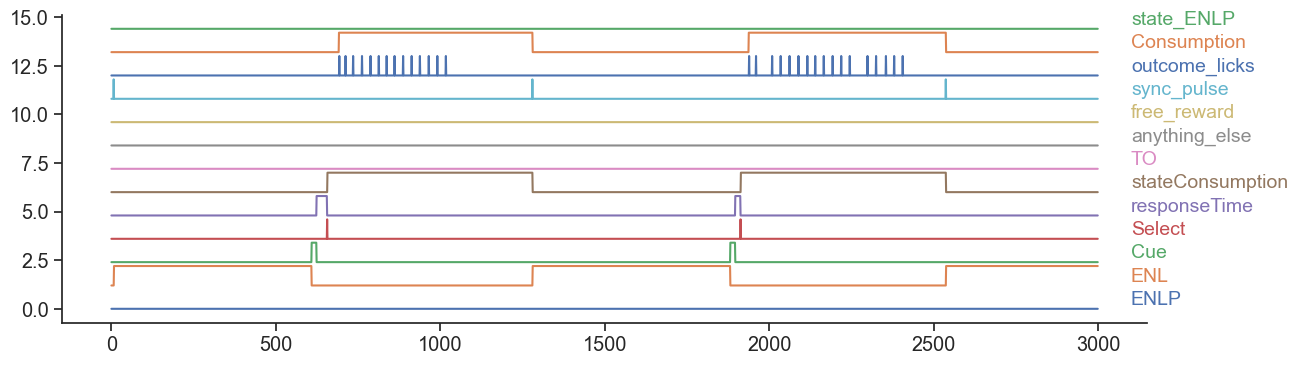

In [82]:
fig, ax = plt.subplots(figsize=(14,4))

cols_exclude = ['nTrial', 'iBlock', 'iTrial', 'iOccurrence', 'iState_start',
       'iState_end', 'analog1', 'analog2', 'session', 'session_clock', 'nENL',
       'state_transition', 'transition_count', 'tState', 'state1', 'lickRight', 'lickLeft',
       'state2','system_nTrial', 'trial_clock', 'iSpout', 'nCue', 'nENL', 'CueP']

i=0
inc_height=1.2
window_start = 0 
window_stop = 3000

sns.set_palette(sns.color_palette(n_colors=30))
for j, key in enumerate(analog.columns.drop(cols_exclude)):
    ax.plot(analog[key][window_start:window_stop]+i, label=key); i+=inc_height
    ax.text(x=window_stop+100, y=i-inc_height, s=key, fontsize=14, va="bottom", color=sns.color_palette()[j]) 
sns.despine()

In [83]:
lick_df.to_csv(savepath / f'{mouse}_{date}_lick_df.csv')
analog.to_csv(savepath / f"{mouse}_{date}_analog_filled.csv")